# Flight Status Prediction 
Data Source: https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022/discussion

## Relevant Definition

**1. How are flight delays calculated?**  
A flight is counted as "on time" if it operated less than 15 minutes later the scheduled time shown in the carriers' Computerized Reservations Systems (CRS). Arrival performance is based on arrival at the gate. Departure performance is based on departure from the gate. Therefore, `DepDel15` is a key indicator of whether a flight is considered delayed.

**2. `DepartureDelayGroups`:**
Departure Delay intervals, every (15 minutes from <-15 to >180)

**3. How are actual time of arrival and departure measured?**  
Actual arrival, departure and elapsed times shall be measured by
the times at which the aircraft arrived at and departed from the gate or
passenger loading area.



## 0. Import Libraries and Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from datetime import datetime
import warnings
warnings.simplefilter("ignore", UserWarning)

pd.set_option("display.max_columns", None)
plt.style.use("ggplot")

In [2]:
# For Later Use to import all data
# !ls -GFlash "/content/drive/MyDrive/Colab/RawData" | grep parquet
# parquet_files = glob("../FlightStatus/RawData/*.parquet")

In [3]:
columns_subset = [
    "FlightDate",
    "Year",
    "Month",
    "DayOfWeek",
    "Flight_Number_Operating_Airline",
    "Airline",
    "Origin",
    "OriginCityName",
    "Dest",
    "DestCityName",
    "Distance",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime", # Actual Departure Time, can be calculated using "DepDelay" column.
    "DepDelay",
    "DepDel15",
    "CRSArrTime", # Scheduled Arrival Time, can be calculated using "CRSElapsedTime" column.
    "ArrTime", # Actual Arrival Time, Can be calculated using "ArrDelay" column.
    "ArrDelay",
    "ArrDel15",
    "CRSElapsedTime",
    "ActualElapsedTime",
    "DepartureDelayGroups",
    "ArrivalDelayGroups"
    #'Quarter', 'DepDelayMinutes', 'ArrDelayMinutes', 'AirTime', 'DayofMonth',"OriginStateName", "DestStateName",
    #'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
    #'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline',
    #'Operating_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
    #'Tail_Number','OriginAirportID','OriginAirportSeqID',
    #'OriginCityMarketID','OriginState', 'OriginStateFips', 'DestAirportID', 'DestAirportSeqID',
    #'DestCityMarketID', 'DestState', 'DestStateFips','OriginWac', 'DestWac', 'DepTimeBlk', 'TaxiOut',
    #'WheelsOff', 'WheelsOn', 'TaxiIn', 'ArrTimeBlk', 'DistanceGroup', 'DivAirportLandings'
]

df_2018 = pd.read_parquet(
    "/content/drive/MyDrive/Colab/RawData/Combined_Flights_2018.parquet",
    columns=columns_subset,
).reset_index(drop=True)

In [4]:
### Data exploration and overview
# df_2018 = pd.read_parquet("../FlightStatus/RawData/Combined_Flights_2018.parquet", engine="fastparquet")
# df_2018.columns
# df_2018.head()
# df_2018.loc[df_2018["DepDel15"] == 1]
# df_2018.info()

## 1. Data Cleaning and Data preprocessing

In [5]:
# Rename columns to make them more intuitive and consistent.
df_2018 = df_2018.rename(
    columns={
        "CRSDepTime": "ScheduledDepTime",
        "CRSElapsedTime": "ScheduledElapsedTime",
        "DepTime": "ActualDepTime",
        "DepDelay": "DepDelayMinutes",
        "CRSArrTime": "ScheduledArrTime",
        "ArrTime": "ActualArrTime",
        "ArrDelay": "ArrDelayMinutes",
        "Flight_Number_Operating_Airline": "FlightNumber",
    }
)

In [6]:
# Dropping those records with both Cancelled and Diverted equal true
i = df_2018.query("Cancelled == True and Diverted == True").index
df_2018.drop(labels=i, axis=0, inplace=True)

In [7]:
# Target label 1: "DepartureDelayGroups"
# Replace the value with "cancelled" and "diverted"
df_2018.loc[df_2018["Cancelled"], "DepartureDelayGroups"] = "C"
df_2018.loc[df_2018["Diverted"], "DepartureDelayGroups" ] = "D"
# Target label 2: ArrivalDelayGroups
# Creating target labels for "Arrival" status
df_2018.loc[df_2018["Cancelled"], "ArrivalDelayGroups"] = "C"
df_2018.loc[df_2018["Diverted"], "ArrivalDelayGroups"] = "D"

In [8]:
# Check if there's still any unassigned DepartureDelayGroups
index_dep = df_2018[df_2018.DepartureDelayGroups.isnull()].index
# When "ScheduledDepTime" = "ActualDepTime", all 3 columns "DepDelayMinutes", "DepDel15", "DepartureDelayGroups" are null
# Assign the correct values for these 3 groups
df_2018.loc[index_dep, "DepDelayMinutes"] = df_2018.loc[index_dep, "ActualDepTime"] - df_2018.loc[index_dep, "ScheduledDepTime"]
df_2018.loc[index_dep, "DepDel15"] = 0
df_2018.loc[index_dep, "DepartureDelayGroups"] = 0

print(df_2018.loc[index_dep, "DepDelayMinutes"].describe())
print(df_2018.loc[index_dep, "DepDel15"].describe())
print(df_2018.loc[index_dep, "DepartureDelayGroups"].describe())

count    1105.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: DepDelayMinutes, dtype: float64
count    1105.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: DepDel15, dtype: float64
count     1105
unique       1
top          0
freq      1105
Name: DepartureDelayGroups, dtype: int64


In [9]:
# Check if there's still any unassigned ArrivalDelayGroups
index_arr = df_2018[df_2018.ArrivalDelayGroups.isnull()].index 
# When "ScheduledArrTime" = "ActualArrTime", all 3 columns "ArrDelayMinutes", "ArrDel15", "ArrivalDelayGroups" are null
# Assign the correct values for these 3 groups
df_2018.loc[index_arr, "ArrDelayMinutes"] = df_2018.loc[index_arr, "ActualArrTime"] - df_2018.loc[index_arr, "ScheduledArrTime"]
df_2018.loc[index_arr, "ArrDel15"] = 0
df_2018.loc[index_arr, "ArrivalDelayGroups"] = 0

print(df_2018.loc[index_arr, "ArrDelayMinutes"].describe())
print(df_2018.loc[index_arr, "ArrDel15"].describe())
print(df_2018.loc[index_arr, "ArrivalDelayGroups"].describe())

count    548.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: ArrDelayMinutes, dtype: float64
count    567.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: ArrDel15, dtype: float64
count     567
unique      1
top         0
freq      567
Name: ArrivalDelayGroups, dtype: int64


In [10]:
# Dropping those records with NA values when the flights were neither Cancelled nor Diverted
df_2018 = df_2018.loc[~((df_2018['DepartureDelayGroups']!='C') & \
             (df_2018['DepartureDelayGroups']!='D') & \
             (df_2018['ActualElapsedTime'].isnull())),]

In [11]:
# Check for duplicates
print("There are {} duplicates in dataset".format(len(df_2018[df_2018.duplicated()])))

There are 0 duplicates in dataset


In [12]:
### If there is any duplicated rows: Return the duplicated row
# df.loc[df.duplicated()] 
## Dropping the duplicated rows by keeping those not duplicated ones using ~ to inverse, and .reset_index(drop=True) will fix problem of index not necessarily  jumping up by a single number each time
# df = df.loc[~df.duplicated(subset=['Coaster_Name','Location','Opening_Date'])].reset_index(drop=True).copy()

In [13]:
# print(df.info())
# print(df.head())
# print(df.columns)

# Datatypes - Category
category = [
    "Year",
    "Month",
    "DayOfWeek",
    "FlightNumber",
    "Airline",
    "Origin",
    "OriginCityName",
    "Dest",
    "DestCityName",
    "DepartureDelayGroups",
    "ArrivalDelayGroups",
]

for c in category:
    df_2018[c] = df_2018[c].astype("category")

# Datatypes - Boolean
boolean = ["DepDel15", "ArrDel15"]
for b in boolean:
    df_2018[b] = df_2018[b].astype(bool)

# Datatypes - DateTime Object
index = df_2018[df_2018["ScheduledDepTime"] < 10].index
df_2018.loc[index,"ScheduledDepTime"] = (
df_2018[df_2018["ScheduledDepTime"] < 10]["ScheduledDepTime"] *10
)
df_2018["ScheduledDepTime"] = df_2018["ScheduledDepTime"].astype("int64").astype(str)
df_2018["ScheduledDepTime"] = pd.to_datetime(df_2018["ScheduledDepTime"],format= '%H%M').dt.time

In [20]:
# Remove unwanted columns
df_2018 = df_2018.drop(["ActualDepTime","ScheduledArrTime","ActualArrTime"], axis=1)

## 2. EDA includes Data visualization

In [15]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5689489 entries, 0 to 5689511
Data columns (total 25 columns):
 #   Column                Dtype         
---  ------                -----         
 0   FlightDate            datetime64[ns]
 1   Year                  category      
 2   Month                 category      
 3   DayOfWeek             category      
 4   FlightNumber          category      
 5   Airline               category      
 6   Origin                category      
 7   OriginCityName        category      
 8   Dest                  category      
 9   DestCityName          category      
 10  Distance              float64       
 11  Cancelled             bool          
 12  Diverted              bool          
 13  ScheduledDepTime      object        
 14  ActualDepTime         float64       
 15  DepDelayMinutes       float64       
 16  DepDel15              bool          
 17  ScheduledArrTime      int64         
 18  ActualArrTime         float64       
 19  

### 2.1 Univariate Analysis Visualization

In [16]:
# Statistical Analysis
Numerical = ["Distance", "DepDelayMinutes", "ArrDelayMinutes", 'ScheduledElapsedTime', 'ActualElapsedTime']
df_2018[Numerical].describe()

,Distance,DepDelayMinutes,ArrDelayMinutes,ScheduledElapsedTime,ActualElapsedTime
count,5.689489e+06,5.604021e+06,5.587165e+06,5.689483e+06,5.587165e+06
mean,7.878035e+02,1.014691e+01,5.415765e+00,1.389092e+02,1.344377e+02
std,5.943091e+02,4.536480e+01,4.745837e+01,7.288397e+01,7.258416e+01
min,1.600000e+01,-1.280000e+03,-1.290000e+03,-9.900000e+01,-1.228000e+03
25%,3.490000e+02,-6.000000e+00,-1.400000e+01,8.600000e+01,8.200000e+01
50%,6.280000e+02,-2.000000e+00,-6.000000e+00,1.200000e+02,1.170000e+02
75%,1.024000e+03,7.000000e+00,8.000000e+00,1.700000e+02,1.650000e+02
max,4.983000e+03,2.625000e+03,2.635000e+03,1.645000e+03,7.570000e+02


In [ ]:
# Categorical Analysis 
# 'Year', 'Month', 'DayOfWeek', 'FlightNumber', 'Airline','Origin', 'OriginCityName', 
# 'Dest', 'DestCityName', 'DepartureDelayGroups', 'ArrivalDelayGroups'
df_2018['Airline'].value_counts()

Southwest Airlines Co.                       1331609
United Air Lines Inc.                         614915
SkyWest Airlines Inc.                         522086
Delta Air Lines Inc.                          458840
American Airlines Inc.                        378722
JetBlue Airways                               297758
Republic Airlines                             197448
Alaska Airlines Inc.                          182705
Spirit Air Lines                              174129
ExpressJet Airlines Inc.                      161955
Mesa Airlines Inc.                            149840
Envoy Air                                     123437
Frontier Airlines Inc.                        117523
Endeavor Air Inc.                             115924
Comair Inc.                                   113211
Air Wisconsin Airlines Corp                    95565
Allegiant Air                                  95192
Horizon Air                                    83937
Hawaiian Airlines Inc.                        

/usr/local/lib/python3.8/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


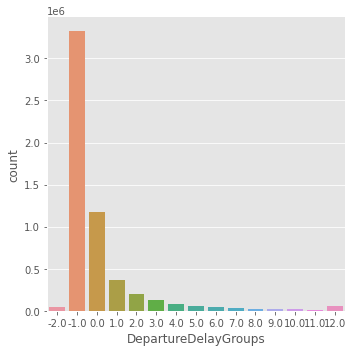

In [ ]:
# Distribution of 'DepartureDelayGroups'
sns.catplot(x='DepartureDelayGroups', data=df_2018, kind = 'count')
plt.show()
pass
## -1.0 and 0.0 is the major groups, which is early and on time departure

/usr/local/lib/python3.8/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/usr/local/lib/python3.8/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


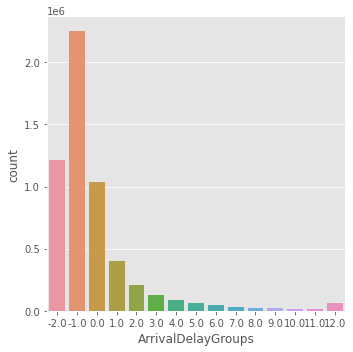

In [ ]:
# Distribution of 'ArrivalDelayGroups'
sns.catplot(x='ArrivalDelayGroups', data=df_2018, kind = 'count')
plt.show()
pass

In [ ]:
Not_Delayed = 0
Delayed = 0
for i in range(-2,13):
  if i <= 0:
    Not_Delayed = Not_Delayed + len(df_2018["DepartureDelayGroups"] == "i")
  else:
    Delayed = Delayed + len(df_2018["DepartureDelayGroups"] == "i")
print("The portion of Delayed flights is {}".format(Not_Delayed/Delayed))

The portion of Delayed flights is 0.25


**Imbalance data**  
The portion of Not Delayed Flights to Delayed Flights is about 4 to 1, indicating an issue of imbalance data, which will in turn cause oversampling problem in machine-learning model. Here we will use SMOTE to generate synthetic samples from the Delayed Flights to address this issue.